In [21]:
import os
import h5py
import sv as SV
import numpy as np
import astropy.table as atable
from astropy.cosmology import FlatLambdaCDM

from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dat_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper/'
sv1 = atable.Table.read(os.path.join(dat_dir, 'ztile-sv1-bright-cumulative.fits'))
sv3 = atable.Table.read(os.path.join(dat_dir, 'ztile-sv3-bright-cumulative.fits'))

In [4]:
sv1_bright = (sv1['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_faint  = (sv1['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0 

sv3_bright = (sv3['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_faint  = (sv3['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

In [5]:
sv1_cuts = ((sv1['Z'] != 1e20) & (sv1['ZWARN'] == 0) & (sv1['DELTACHI2'] > 15))
sv3_cuts = ((sv3['Z'] != 1e20) & (sv3['ZWARN'] == 0) & (sv3['DELTACHI2'] > 15))

In [6]:
print('SV1: %i redshifts' % np.sum(sv1_cuts))
print('SV3: %i redshifts' % np.sum(sv3_cuts))

SV1: 169094 redshifts
SV3: 760868 redshifts


In [7]:
def stephist(nh, _edges):
    bin_edges = np.sort(list(_edges) + list(_edges[1:-1]))
    return bin_edges, np.array([[x, x] for x in nh]).flatten()

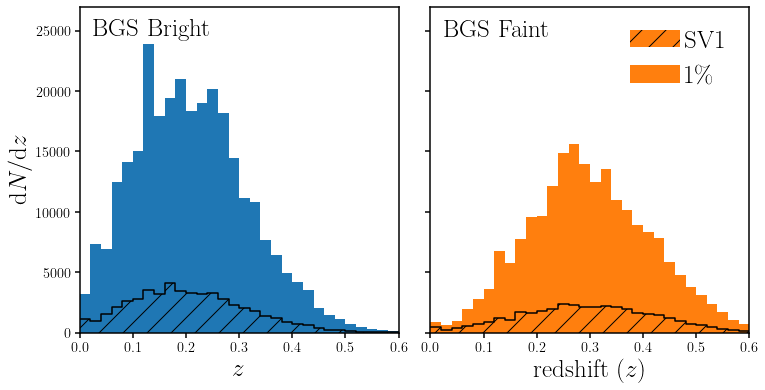

In [28]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)

nh, edges = np.histogram(sv1['Z'][sv1_bright & sv1_cuts], range=(0., 0.6), bins=30)
bin_edges, nhist0 = stephist(nh, edges)

sub.fill_between(bin_edges, np.zeros(len(bin_edges)), nhist0, facecolor='C0', hatch='/')
sub.plot(bin_edges, nhist0, c='k')

nh, edges = np.histogram(sv3['Z'][sv3_bright & sv3_cuts], range=(0., 0.6), bins=30)
bin_edges, nhist1 = stephist(nh, edges)

sub.fill_between(bin_edges, nhist0, nhist0 + nhist1, facecolor='C0')

sub.text(0.025, 2.6e4, 'BGS Bright', ha='left', va='top', fontsize=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r'${\rm d}N/{\rm d}z$', fontsize=25)
sub.set_ylim(0., 2.7e4)

sub = fig.add_subplot(122)

nh, edges = np.histogram(sv1['Z'][sv1_faint & sv1_cuts], range=(0., 0.6), bins=30)
bin_edges, nhist0 = stephist(nh, edges)

sub.fill_between(bin_edges, np.zeros(len(bin_edges)), nhist0, facecolor='C1', hatch='/', label='SV1')
sub.plot(bin_edges, nhist0, c='k')

nh, edges = np.histogram(sv3['Z'][sv3_faint & sv3_cuts], range=(0., 0.6), bins=30)
bin_edges, nhist1 = stephist(nh, edges)

sub.fill_between(bin_edges, nhist0, nhist0 + nhist1, facecolor='C1', label=r'$1\%$')

sub.text(0.025, 2.6e4, 'BGS Faint', ha='left', va='top', fontsize=25)
sub.legend(loc='upper right', handletextpad=0.2, fontsize=25)
sub.set_xlabel('redshift ($z$)', fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_yticklabels([])
sub.set_ylim(0., 2.7e4)

fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/dndz.pdf', bbox_inches='tight')

In [22]:
cosmo = FlatLambdaCDM(70, 0.3)
area = 126.7048 #len(ran)/2500.
print('area is '+str(area))

area is 126.7048


In [23]:
zmin, zmax = 0.01, 0.6
nbin = int((zmax - zmin)/0.01)
zhist = np.histogram(sv3['Z'][sv3_cuts], bins=nbin, range=(zmin,zmax))
zhist_bright = np.histogram(sv3['Z'][sv3_bright & sv3_cuts], bins=nbin, range=(zmin,zmax))
zhist_faint  = np.histogram(sv3['Z'][sv3_faint & sv3_cuts], bins=nbin, range=(zmin,zmax))

zmid, nbarz, nbarz_bright, nbarz_faint = [], [], [], []
for i in range(nbin):
    zl = zhist[1][i]
    zh = zhist[1][i+1]
    zmid.append((zh+zl)/2.)
    voli = area/(360.*360./np.pi)*((cosmo.comoving_volume(zh).value - cosmo.comoving_volume(zl).value)*cosmo.h**3)
    nbarz.append(zhist[0][i]/voli)
    nbarz_bright.append(zhist_bright[0][i]/voli)
    nbarz_faint.append(zhist_faint[0][i]/voli)    

In [24]:
z_fdr = np.array([5.093e-2, 6.120e-2, 9.042e-2, 1.305e-1, 2.298e-1, 2.910e-1, 3.413e-1, 3.617e-1, 4.154e-1, 4.514e-1, 5.701e-1])
nbarz_fdr = np.array([3.699e-2, 5.199e-2, 3.505e-2, 2.161e-2, 8.065e-3, 4.156e-3, 2.180e-3, 1.579e-3, 6.563e-4, 3.037e-4, 1.207e-5])

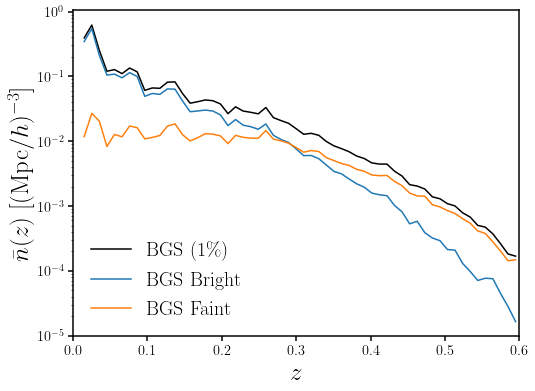

In [29]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.plot(zmid, nbarz, c='k', label='BGS ($1\%$)')
sub.plot(zmid, nbarz_bright, c='C0', label='BGS Bright')
sub.plot(zmid, nbarz_faint, c='C1', label='BGS Faint')
#sub.plot(z_fdr, nbarz_fdr, c='k', ls='--', label='FDR')
sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel('$z$', fontsize=25)
sub.set_xlim(0., 0.6)
sub.set_ylabel(r'$\bar{n}(z)$ [$({\rm Mpc}/h)^{-3}$]', fontsize=25)
sub.set_yscale('log')
fig.savefig('figs/nofz.pdf', bbox_inches='tight')